In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.insert(0, os.path.abspath('../../.'))
from tqdm import tqdm
import time

import torch
import torch.nn as nn
# from sklearn import svm
from thundersvm import *
from matplotlib import pyplot as plt
import cv2

from src.model.SparseNet import SparseNet
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from src.model.FolderDataset import FolderPatchDataset
from src.utils.cmd_line import parse_args
from src.scripts.plotting import plot_rf
from src.utils.visualize import slice_plot, merge_patch

## 1. sparse coding inference

In [2]:
device_name = 'cuda:0'

root_path = '/home/xd/data/defect_detection/data/focusight1_round1_train_part1'
tc_subpath = 'TC_images'
tc_path = os.path.join(root_path, tc_subpath)

model_path = './trained_models'
train_name = 'sparse-net'
train_id = 'p1-04'
checkpoint_epoch = 10
checkpoint_path = os.path.join(
    model_path,
    '{}_{}'.format(train_name, train_id),
    'ckpt_{}.pth'.format(checkpoint_epoch)
)
# a temp solution
checkpoint_path = '../../trained_models/ckpt-990.pth'

patch_size = 10
border_size = 4
n_neuron = 400
r_learning_rate = 1e-2
reg = 5e-3

batch_ratio = 2000

NU = 0.2
KERNEL = 'rbf'
GAMMA = 0.1

In [3]:
dataset = FolderPatchDataset(
    patch_size, patch_size,
    folder=tc_path,
    training=False
)
dataloader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=dataset.N*batch_ratio,
    num_workers=8
)

100%|██████████| 16000/16000 [00:06<00:00, 2288.42it/s]


In [4]:
device = torch.device(device_name)

model = SparseNet(
    n_neuron,
    patch_size,
    R_lr=r_learning_rate,
    lmda=reg,
    device=device
)

model = torch.load(checkpoint_path, map_location='cpu')
model.to(device)

/home/xd/anaconda3/envs/cc/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'src.model.SparseNet.SparseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


SparseNet(
  (U): Linear(in_features=400, out_features=100, bias=False)
)

In [5]:
model.eval()

preds = []
resps = []
losses = []

for img_batch in tqdm(dataloader, total=len(dataloader), file=sys.stdout):
    img_batch = img_batch.reshape(img_batch.shape[0], -1).to(device)
    
    pred = model(img_batch)
    preds.append(pred.cpu().detach())
    
    resps.append(model.R.cpu().detach())
    losses.append(model.r_loss)
    

100%|██████████| 8/8 [02:52<00:00, 21.59s/it]


In [6]:
del(model)
torch.cuda.empty_cache()

In [7]:
np_preds = [pred.numpy() for pred in preds]
np_preds = np.concatenate(np_preds)

np_resps = [resp.numpy() for resp in resps]
np_resps = np.concatenate(np_resps)

np_losses = [loss.numpy() for loss in losses]
np_losses = np.concatenate(np_losses)

print(np_preds.shape)
print(np_resps.shape)
print(np_losses.shape)

(2304000, 100)
(2304000, 400)
(2304000, 100)


## 2. OCSVM inference

In [8]:
clf = OneClassSVM(nu=NU, kernel=KERNEL, gamma=GAMMA, verbose=True)
clf.load_from_file('../../svdd.ckpt')

In [9]:
start_ts = time.time()
svdd_resps = clf.predict(np_resps)
end_ts = time.time()

print('infer duration: {}s'.format(end_ts-start_ts))

infer duration: 305.6937732696533s


In [10]:
img_resps = svdd_resps.reshape(-1, dataset.N)
print(img_resps.shape)

img_preds = np_preds.reshape(-1, dataset.N, patch_size, patch_size)
print(img_preds.shape)
merged_imgs = [merge_patch(preds, dataset.cols, dataset.rows, patch_size, patch_size) for preds in img_preds]

img_losses = np_losses.reshape(-1, dataset.N, patch_size, patch_size)
print(img_losses.shape)
merged_losses = [merge_patch(loss, dataset.cols, dataset.rows, patch_size, patch_size) for loss in img_losses]

(16000, 144)
(16000, 144, 10, 10)
(16000, 144, 10, 10)


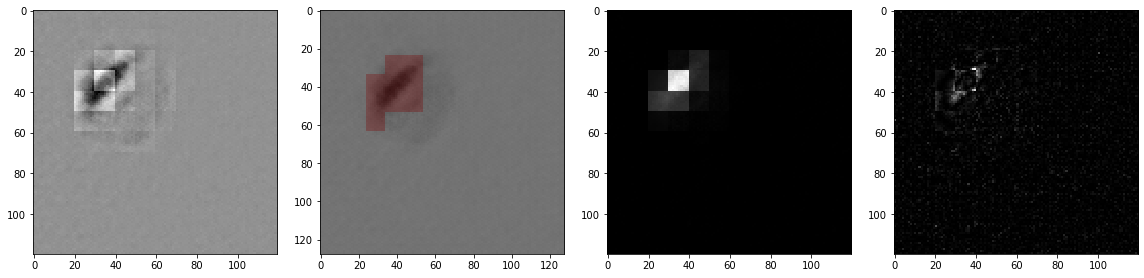

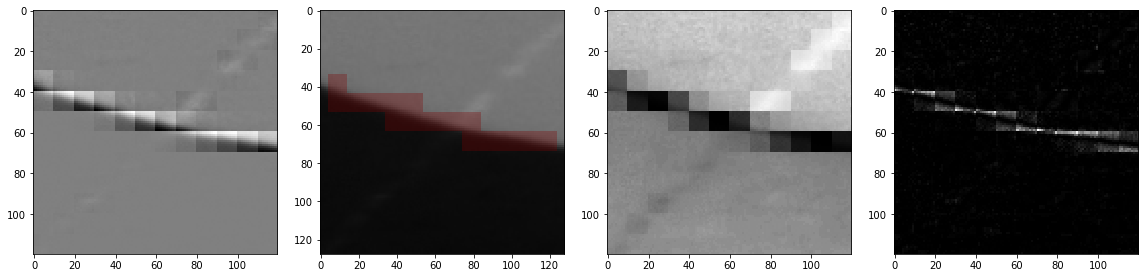

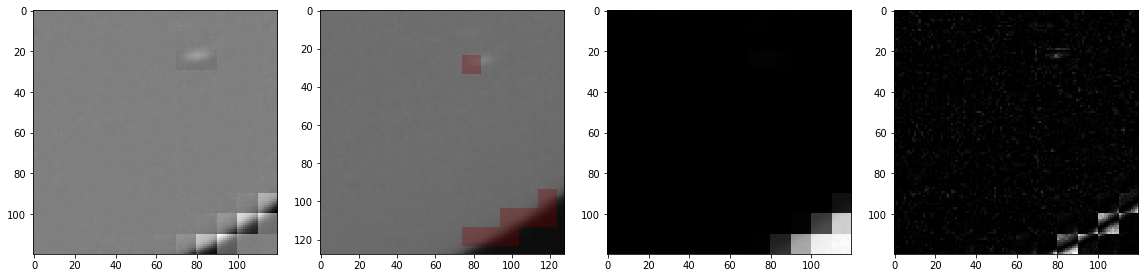

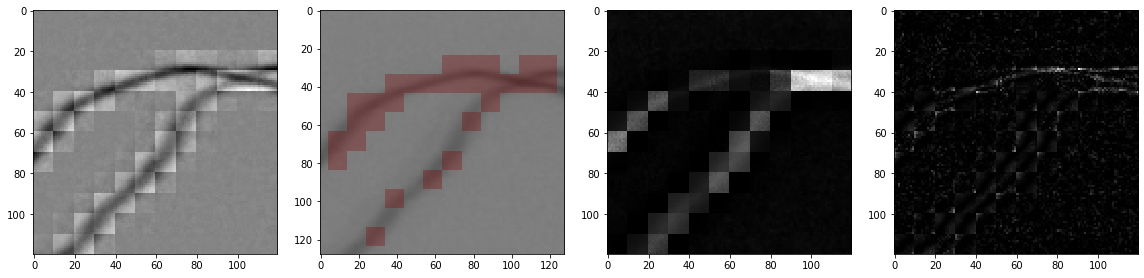

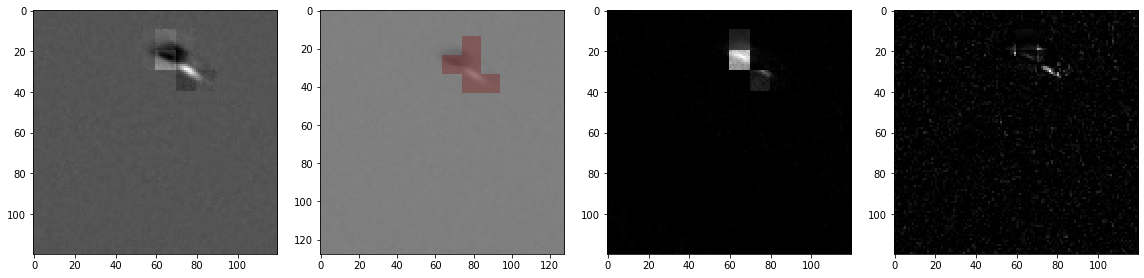

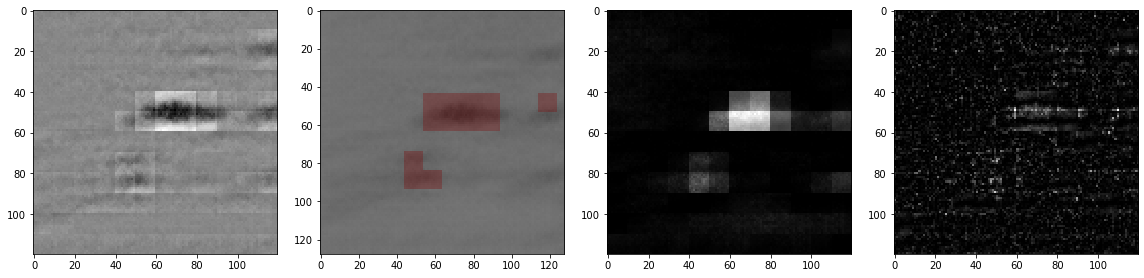

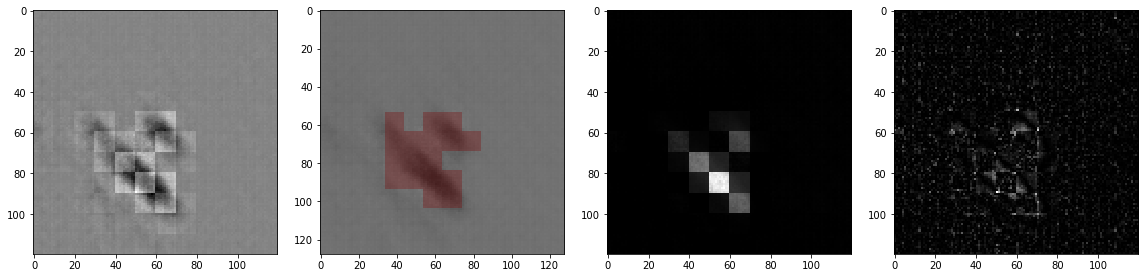

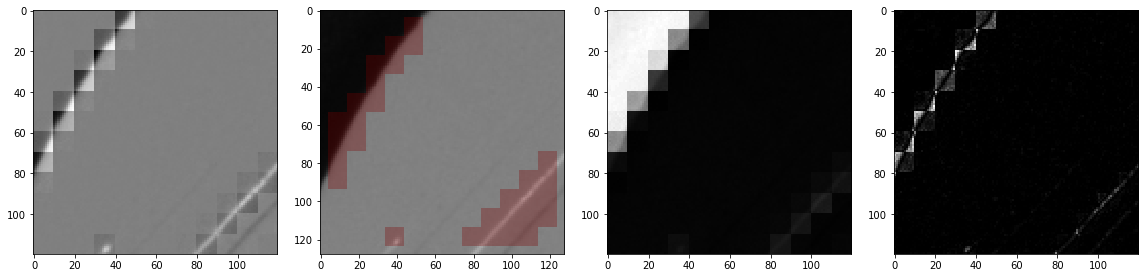

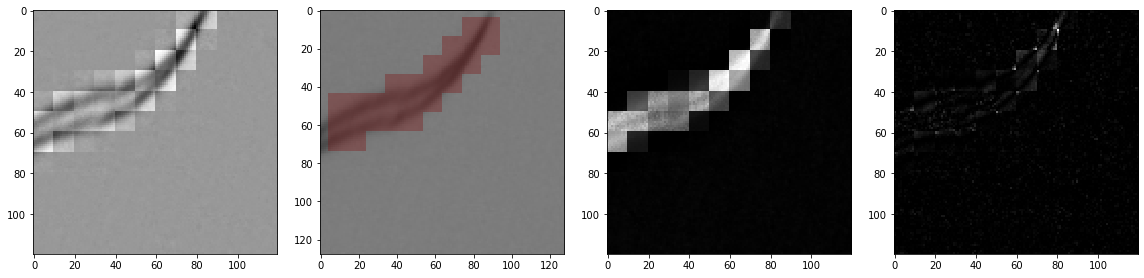

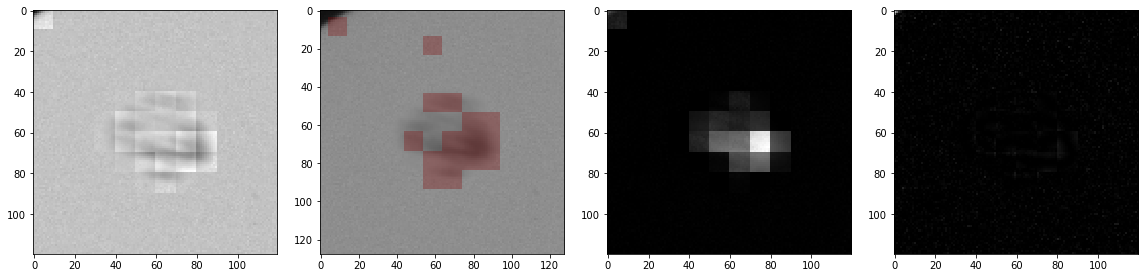

In [32]:
for i in range(10):
    masked_img = slice_plot(
        os.path.join(dataset.folder, dataset.image_filenames[i]),
        patch_size,
        border_size,
        img_resps[i]*-1,
        (128, 0, 0)
    )
    
    fig=plt.figure(figsize=(16,12))

    plt.subplot(1, 4, 1)
    merged_img = merged_imgs[i]
    plt.imshow(merged_img, 'gray')
    
    plt.subplot(1, 4, 2)
    plt.imshow(masked_img)
    
    img = cv2.imread(os.path.join(dataset.folder, dataset.image_filenames[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    img = img[border_size:h-border_size, border_size:w-border_size]/255.
    
    img = img - img.mean()
    merged_img = merged_img - merged_img.mean()
    
    loss_img = (img - merged_img) ** 2

    plt.subplot(1, 4, 3)
    plt.imshow(loss_img, 'gray')
    
    merged_loss = merged_losses[i]
    plt.subplot(1, 4, 4)
    plt.imshow(merged_loss, 'gray')
    
    plt.tight_layout()
    plt.show()